Mounted at /content/drive


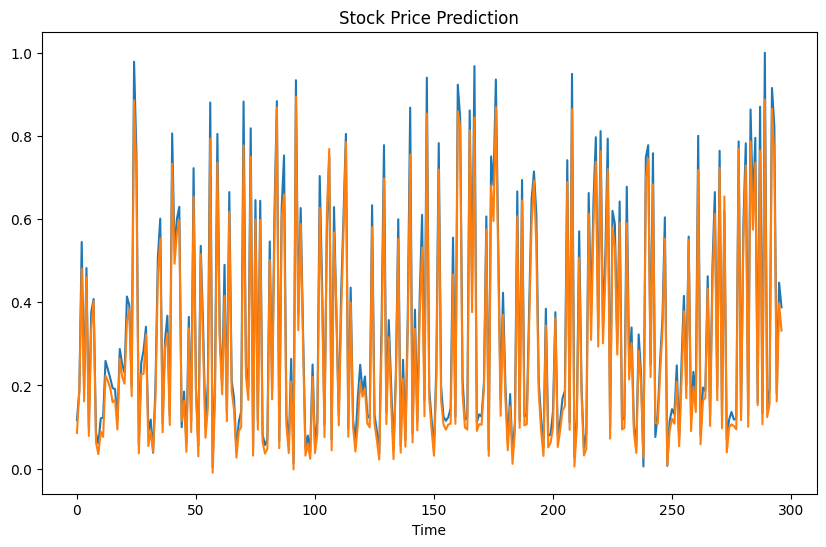

Root Mean Squared Error: 0.041668567806482315


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


from google.colab import drive
drive.mount('/content/drive')


data = pd.read_csv('/content/drive/MyDrive/Final project PTTK/VIB Historical Data.csv')

# Convert 'Date' to datetime and sort the dataframe by date
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Normalizing the 'Price' data
scaler = MinMaxScaler(feature_range=(0, 1))
price_data = data['Price'].values.reshape(-1, 1)
scaled_price = scaler.fit_transform(price_data)

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(scaled_price, seq_length)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create TensorDatasets and DataLoaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

d_model = 64

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.fc_in = nn.Linear(1, d_model)  # New layer to adjust input feature size
        self.transformer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=128, dropout=0.1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(d_model * seq_length, 64)  # Adjust based on sequence length
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc_in(x)  # Adjust input feature size
        x = self.transformer(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = TransformerModel().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# Evaluate the model
def evaluate(model, test_loader, criterion):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    return mean_squared_error(actuals, predictions, squared=False)

# Train the model
train(model, train_loader, criterion, optimizer, epochs=100)

# Evaluate the model
rmse = evaluate(model, test_loader, criterion)

# Visualize the results
def plot_results(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    plt.figure(figsize=(10,6))
    plt.plot(actuals, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.show()

plot_results(model, test_loader)

print(f"Root Mean Squared Error: {rmse}")


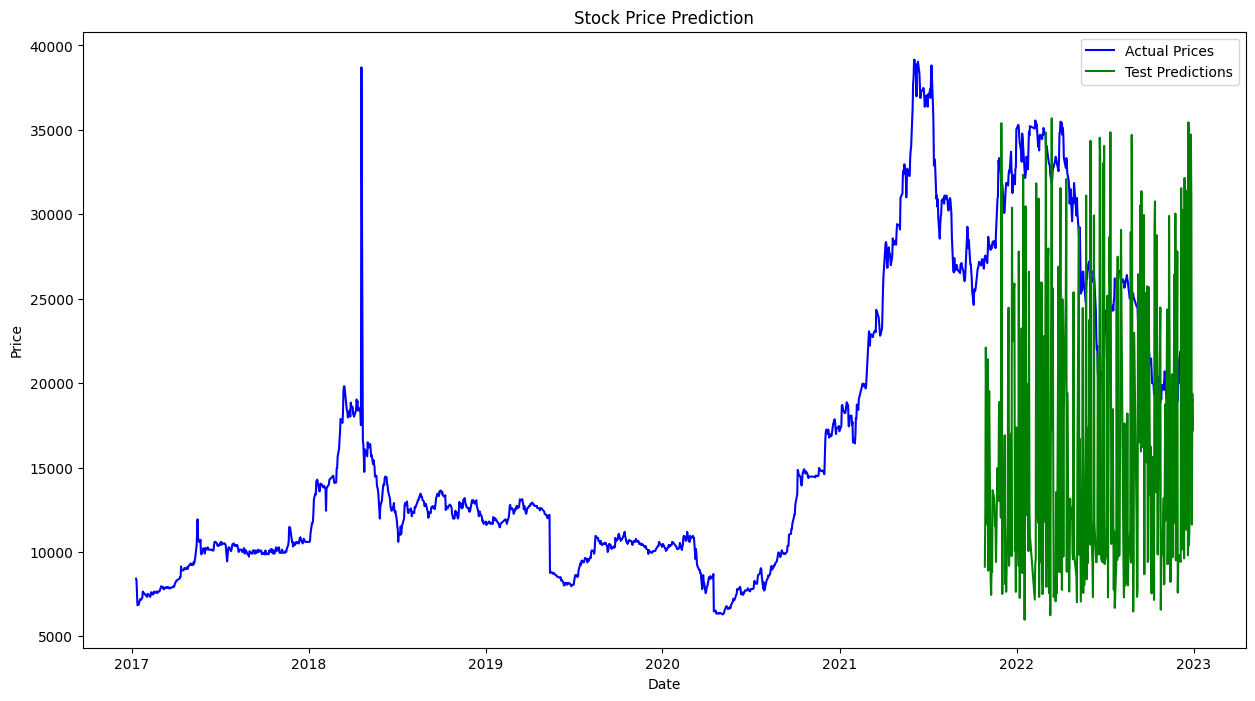

In [4]:
# Function to generate predictions
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            predictions.append(y_pred.cpu().detach().numpy())
    return np.vstack(predictions)

# Generate predictions
train_pred = predict(model, train_loader)
test_pred = predict(model, test_loader)

# Inverse transform to get back to the original scale of prices
train_pred_original = scaler.inverse_transform(train_pred).flatten()
test_pred_original = scaler.inverse_transform(test_pred).flatten()

# Prepare the date index for plotting
dates = data['Date'][seq_length:].reset_index(drop=True)

# Create separate dataframes for training and testing predictions
train_dates = dates[:len(train_pred_original)]
test_dates = dates[len(train_pred_original):len(train_pred_original) + len(test_pred_original)]

train_df = pd.DataFrame({'Date': train_dates, 'Price': train_pred_original})
test_df = pd.DataFrame({'Date': test_dates, 'Price': test_pred_original})

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(data['Date'], data['Price'], label='Actual Prices', color='blue')
#plt.plot(train_df['Date'], train_df['Price'], label='Training Predictions', color='orange')
plt.plot(test_df['Date'], test_df['Price'], label='Test Predictions', color='green')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Assuming testY and y_pred_rf are already defined
# Calculate R-squared (R2) Score
r2 = r2_score(y_test, test_df['Price'])
print(f'R-squared: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, test_df['Price'])
print(f'Mean Absolute Percentage Error: {mape}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, test_df['Price']))
print(f'Root Mean Squared Error: {rmse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, test_df['Price'])
print(f'Mean Absolute Error: {mae}')